# Anomaly Detection

In [1]:
import json
import zipfile
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import scipy.stats as ss

plt.style.use('dark_background')

Define absolute path to data.

In [2]:
data_path = ABSOLUTE_PATH_TO_DATA
unzipped_path = data_path+"/unzipped/"

Define examples for OK and non-OK behaviour and read them.

In [3]:
ok_files = ["OpcUA_PANE_BZ___2022_03_16__11_05_01.csv", "OpcUA_PANE_BZ___2021_12_20__07_49_41.csv",
            "OpcUA_PANE_BZ___2021_12_20__10_05_33.csv"]
nok_files = ["OpcUA_PANE_BZ___2021_12_21__10_33_00.csv", "OpcUA_PANE_BZ___2022_03_16__08_43_38.csv",
             "OpcUA_PANE_BZ___2022_05_24__15_16_19.csv", "OpcUA_PANE_BZ___2022_05_24__08_31_56.csv",
             "OpcUA_PANE_BZ___2022_05_25__09_44_06.csv"]

In [4]:
ok_dfs = []
for file in ok_files:
    df = pd.read_csv(data_path+"/csv/"+file, index_col=0)
    df.index = pd.to_datetime(df.index, infer_datetime_format=True)  # reconvert index to datetime
    ok_dfs.append(df)
    
nok_dfs = []
for file in nok_files:
    df = pd.read_csv(data_path+"/csv/"+file, index_col=0)
    df.index = pd.to_datetime(df.index, infer_datetime_format=True)  # reconvert index to datetime
    nok_dfs.append(df)

## Detect Persistent Anomalies

Define a function to return regions where anomalies with consistent positive deviations from SOLL are likely.

In [5]:
def get_anomaly_regions(diff, index, thresh=850):
    """Return possible anomaly regions with consistent positive deviation from SOLL."""
    
    anomaly_regions = []
    c_sum = 0
    start_anomaly = 0
    last_zero = 0
    current_anomaly = False
    current_anomaly_coords = [0, 0]
    for i, point in enumerate(diff):
        c_sum += point
        if c_sum > thresh and not current_anomaly:
            current_anomaly = True
            current_anomaly_coords[0] = index[last_zero]  # set begin of anomaly
        if point == 0:
            if current_anomaly:
                current_anomaly_coords[1] = index[i]  # set end of anomaly
                anomaly_regions.append(list(current_anomaly_coords))
                current_anomaly = False
            last_zero = i
            c_sum = 0

    return anomaly_regions

Plot the examples for OK and nOK with such possible anomalies and mark them in green.

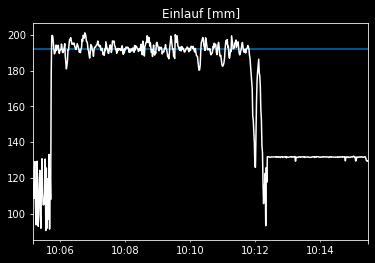

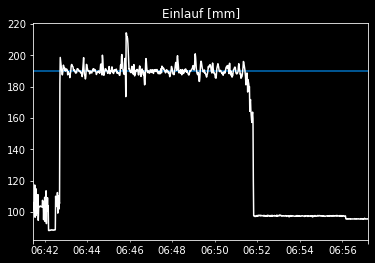

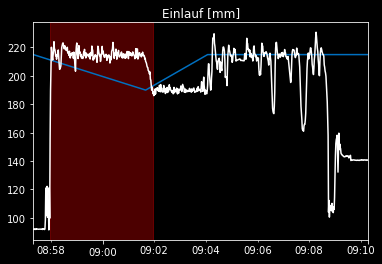

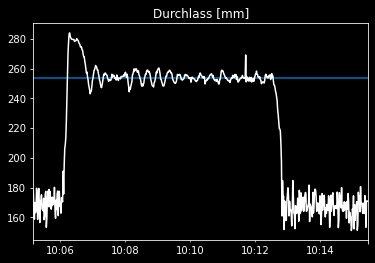

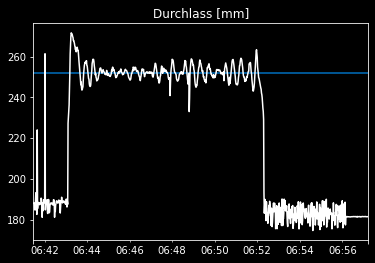

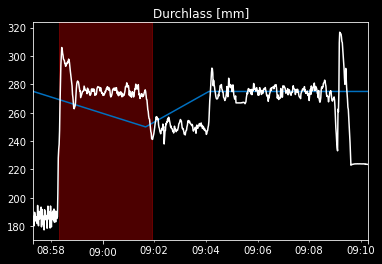

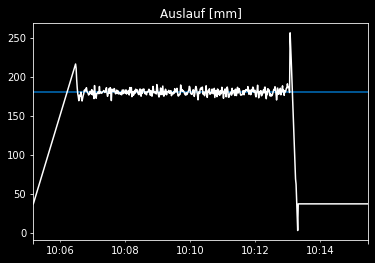

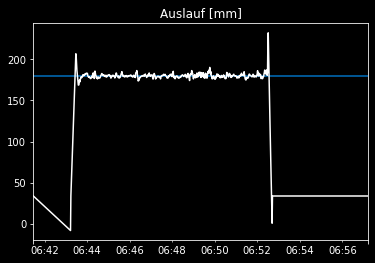

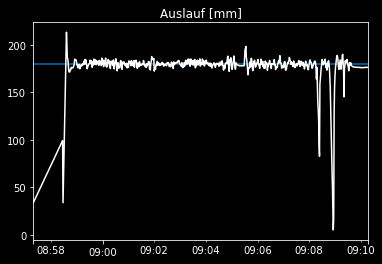

In [6]:
for idx in [0, 1, 2]:
    idx_name = {0:"Einlauf", 1:"Durchlass", 2:"Auslauf"}[idx]
    for i, df in enumerate(ok_dfs):
        diff = df[f"distanceSensors[{idx}].calcValueInMm"] - df[f"quadroSensorsAutoCommands[{idx}].setpointInMm"]
        index = diff.index
        diff = savgol_filter(np.where(diff > 0, diff, 0), 7, 2)  # smooth function
        anomaly_regions = get_anomaly_regions(diff, index)

        df[f"quadroSensorsAutoCommands[{idx}].setpointInMm"].plot(label="SOLL", color="#0070C0")
        df[f"distanceSensors[{idx}].calcValueInMm"].plot(label="IST", color="white")
        for anomaly in anomaly_regions:
            plt.axvspan(anomaly[0], anomaly[1], color='#FF0000', alpha=0.3)
        plt.title(f'{idx_name} [mm]')
        plt.savefig(f"plots/consistent_OK_{i}_{idx_name}", transparent=True, bbox_inches='tight', dpi=250)
        plt.show()

nOK

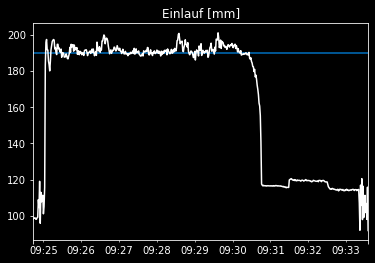

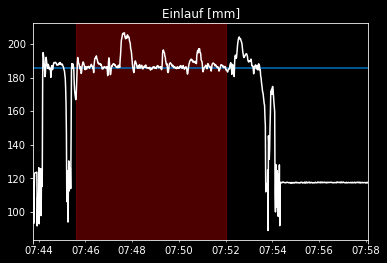

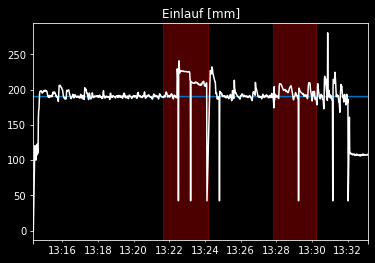

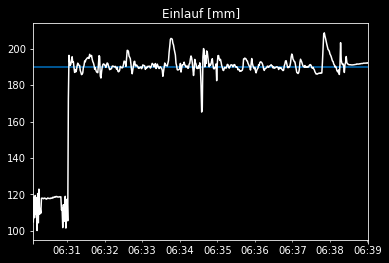

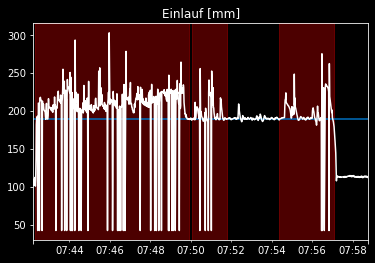

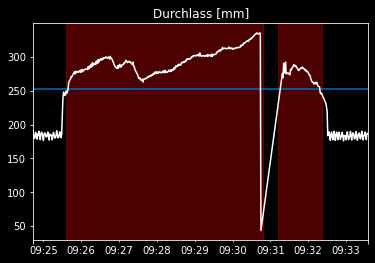

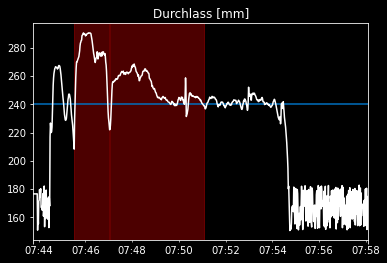

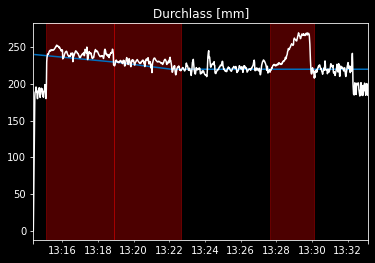

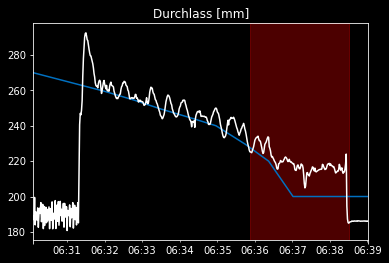

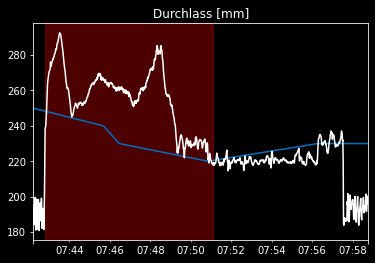

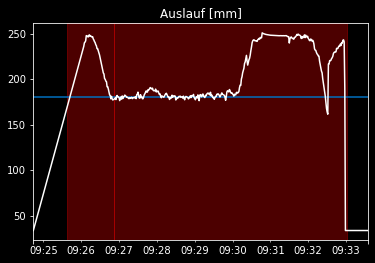

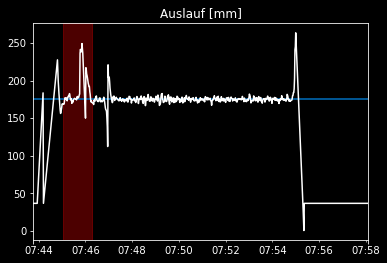

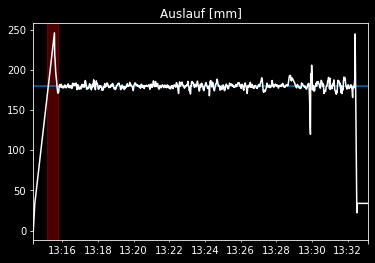

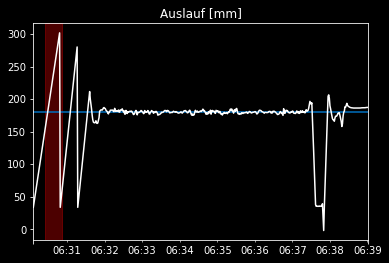

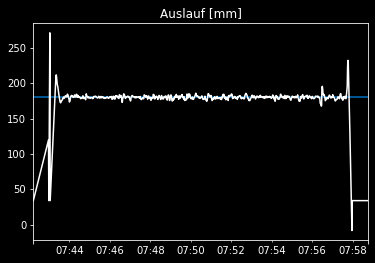

In [7]:
for idx in [0, 1, 2]:
    idx_name = {0:"Einlauf", 1:"Durchlass", 2:"Auslauf"}[idx]
    for i, df in enumerate(nok_dfs):
        diff = df[f"distanceSensors[{idx}].calcValueInMm"] - df[f"quadroSensorsAutoCommands[{idx}].setpointInMm"]
        index = diff.index
        diff = savgol_filter(np.where(diff > 0, diff, 0), 7, 2)  # smooth function
        anomaly_regions = get_anomaly_regions(diff, index)

        df[f"quadroSensorsAutoCommands[{idx}].setpointInMm"].plot(label="SOLL", color="#0070C0")
        df[f"distanceSensors[{idx}].calcValueInMm"].plot(label="IST", color="white")
        for anomaly in anomaly_regions:
            plt.axvspan(anomaly[0], anomaly[1], color='#FF0000', alpha=0.3)
        plt.title(f'{idx_name} [mm]')
        plt.savefig(f"plots/consistent_nOK_{i}_{idx_name}", transparent=True, bbox_inches='tight', dpi=250)
        plt.show()

## Detect Point Anomalies

Detect point anomalies seperately with the Z-score. Plot the examples for OK and nOK with such possible anomalies and mark them in green.

OK

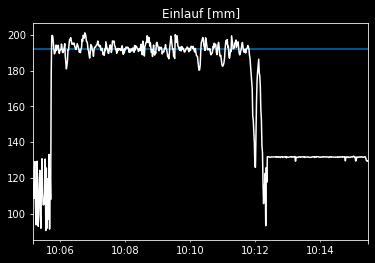

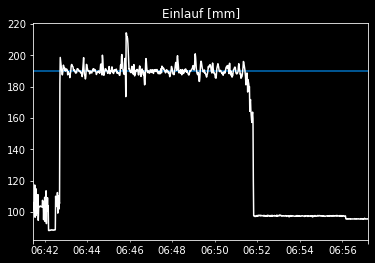

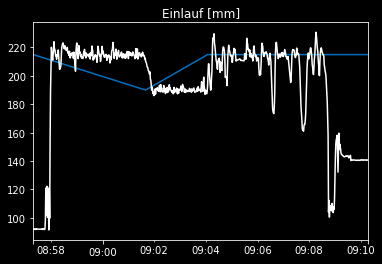

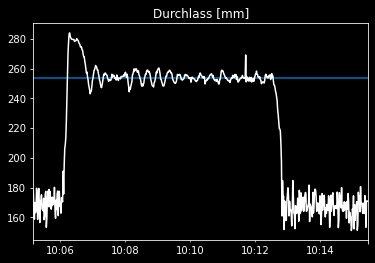

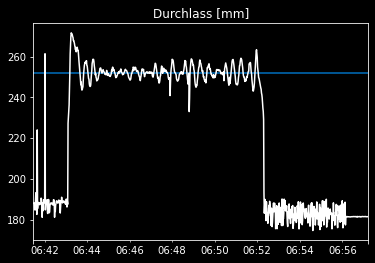

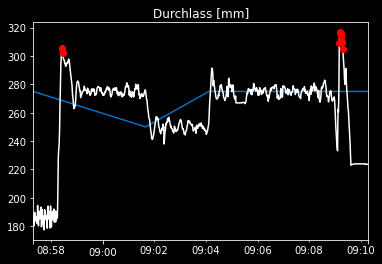

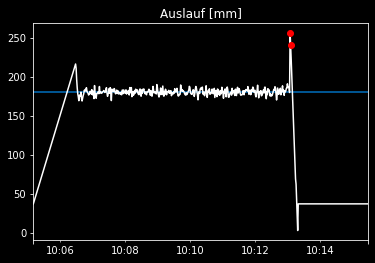

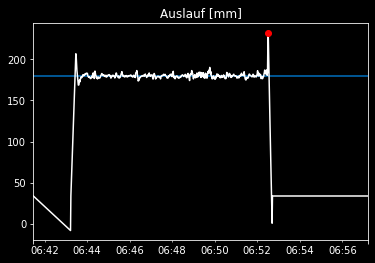

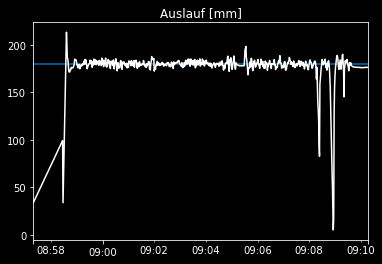

In [8]:
for idx in [0, 1, 2]:
    idx_name = {0:"Einlauf", 1:"Durchlass", 2:"Auslauf"}[idx]
    for df in ok_dfs:
        zscore = ss.zscore(df[f'distanceSensors[{idx}].calcValueInMm'])

        df[f"quadroSensorsAutoCommands[{idx}].setpointInMm"].plot(zorder=1, color="#0070C0")
        df[f'distanceSensors[{idx}].calcValueInMm'].plot(zorder=2, color="white")
        highlight_x = []
        highlight_y = []
        for dt_idx in zscore[zscore > 1.5].index:
            highlight_x.append(dt_idx)
            highlight_y.append(df[f'distanceSensors[{idx}].calcValueInMm'].loc[dt_idx])
        plt.scatter(x=highlight_x, y=highlight_y, c="#FF0000", zorder=3)
        plt.title(f'{idx_name} [mm]')
        plt.savefig(f"plots/point_OK_{i}_{idx_name}", transparent=True, bbox_inches='tight', dpi=250)
        plt.show()

nOK

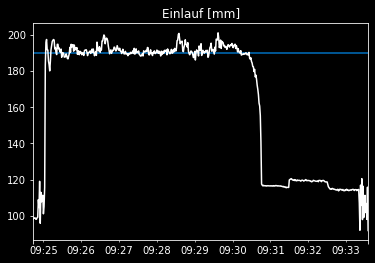

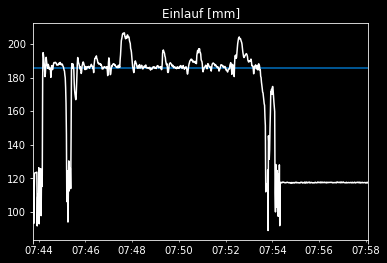

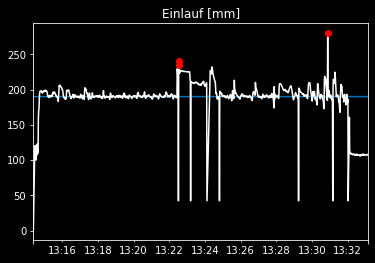

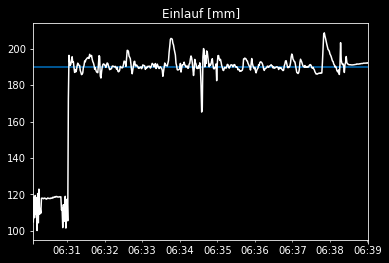

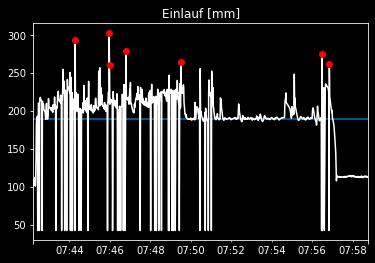

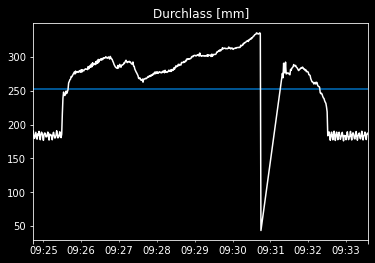

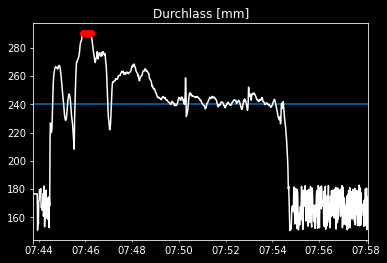

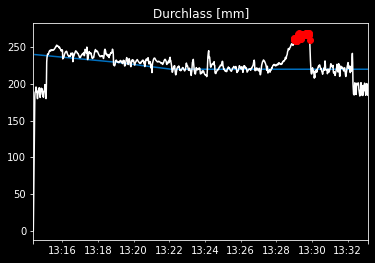

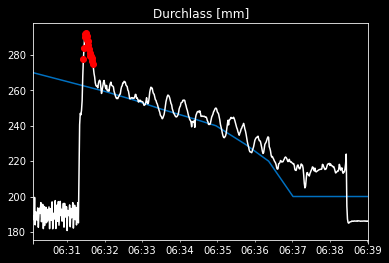

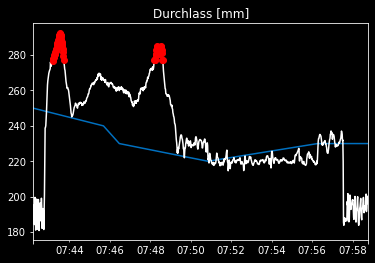

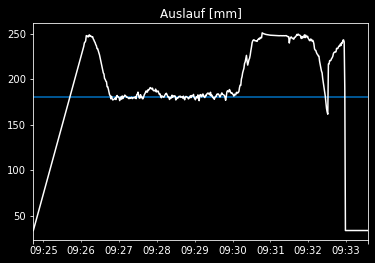

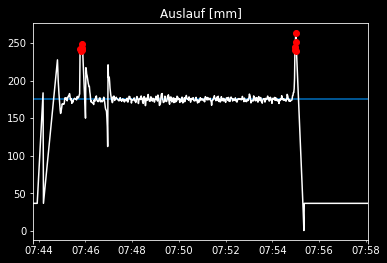

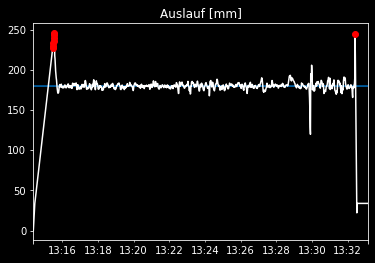

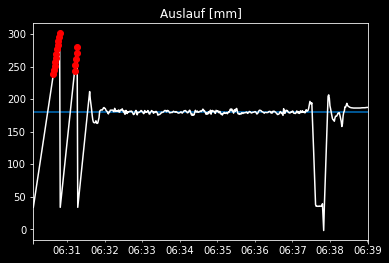

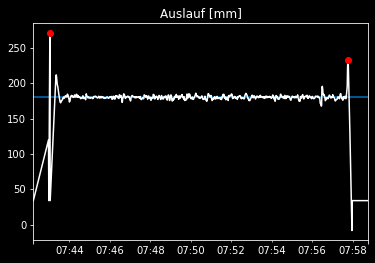

In [9]:
for idx in [0, 1, 2]:
    idx_name = {0:"Einlauf", 1:"Durchlass", 2:"Auslauf"}[idx]
    for df in nok_dfs:
        zscore = ss.zscore(df[f'distanceSensors[{idx}].calcValueInMm'])

        df[f"quadroSensorsAutoCommands[{idx}].setpointInMm"].plot(zorder=1, color="#0070C0")
        df[f'distanceSensors[{idx}].calcValueInMm'].plot(zorder=2,  color="white")
        highlight_x = []
        highlight_y = []
        for dt_idx in zscore[zscore > 1.6].index:
            highlight_x.append(dt_idx)
            highlight_y.append(df[f'distanceSensors[{idx}].calcValueInMm'].loc[dt_idx])
        plt.scatter(x=highlight_x, y=highlight_y, c="#FF0000", zorder=3)
        plt.title(f'{idx_name} [mm]')
        plt.savefig(f"plots/point_nOK_{i}_{idx_name}", transparent=True, bbox_inches='tight', dpi=250)
        plt.show()